In [ ]:
!pip install cdsapi
import cdsapi

dataset = "reanalysis-era5-single-levels"
request = {
    "product_type": ["reanalysis"],
    "variable": [
        "10m_u_component_of_wind",
        "10m_v_component_of_wind"
    ],
    "year": ["2023"],
    "month": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12"
    ],
    "day": [
        "01", "02", "03",
        "04", "05", "06",
        "07", "08", "09",
        "10", "11", "12",
        "13", "14", "15",
        "16", "17", "18",
        "19", "20", "21",
        "22", "23", "24",
        "25", "26", "27",
        "28", "29", "30",
        "31"
    ],
    "time": ["12:00"],
    "data_format": "grib",
    "download_format": "unarchived",
    "area": [42.1, -73.8, 40.9, -71.7]
}

client = cdsapi.Client()
client.retrieve(dataset, request).download()


2025-05-07 00:50:41,844 INFO [2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
INFO:datapi.legacy_api_client:[2024-09-26T00:00:00] Watch our [Forum](https://forum.ecmwf.int/) for Announcements, news and other discussed topics.
2025-05-07 00:50:41,848 WARNING [2024-06-16T00:00:00] CDS API syntax is changed and some keys or parameter names may have also changed. To avoid requests failing, please use the "Show API request code" tool on the dataset Download Form to check you are using the correct syntax for your API request.
2025-05-07 00:50:42,528 INFO Request ID is d3968b49-87e3-4747-b7e6-376b3699143d
INFO:datapi.legacy_api_client:Request ID is d3968b49-87e3-4747-b7e6-376b3699143d
2025-05-07 00:50:42,748 INFO status has been updated to accepted
INFO:datapi.legacy_api_client:status has been updated to accepted
2025-05-07 00:50:51,556 INFO status has been updated to running
INFO:datapi.legacy_api_client:status has been upd

1d6ececb94581bee40324908ec2d02ad.grib:   0%|          | 0.00/141k [00:00<?, ?B/s]

'1d6ececb94581bee40324908ec2d02ad.grib'

In [ ]:
import zipfile
import os

# Step 1: Unzip the bathymetry data
zip_file_path = '/content/GEBCO_05_May_2025_6f94d4c8432f.zip'
unzip_dir = '/content/bathymetry_data/'

os.makedirs(unzip_dir, exist_ok=True)

with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(unzip_dir)

# Step 2: Find the NetCDF bathymetry file recursively
bathymetry_file = None
for root, dirs, files in os.walk(unzip_dir):
    for file in files:
        if file.endswith('.nc'):
            bathymetry_file = os.path.join(root, file)
            break
    if bathymetry_file:
        break

# Step 3: Generate SWAN input
if bathymetry_file:
    wind_file = '/path/to/wind_2023.nc'  # Replace with the actual path to your wind data

    swan_input = f"""
    PROJECT 'wave_forecast' '001'

    MODE STATionary

    CGRID CURVilinear 100 100 0.1 0.1 CIRCLE 36

    READGRID COORDINATES 1 '{bathymetry_file}' 4 0 FREE

    WINDFIELD
      WIND SPEED '{wind_file}' VARIABLE 'U10'
      WIND DIRECTION '{wind_file}' VARIABLE 'DIR'

    COMPUTE

    OUTPUT QUANTITY 'Hs' 'Tm' 'Dir' 'Xp' 'Yp'

    SAVE GRID 'output.nc'
    """

    with open('/content/input.swn', 'w') as f:
        f.write(swan_input)

    print("✅ SWAN input file created successfully!")
    print("📄 Bathymetry file used:", bathymetry_file)
else:
    print("❌ No NetCDF bathymetry file found!")


✅ SWAN input file created successfully!
📄 Bathymetry file used: /content/bathymetry_data/GEBCO_05_May_2025_6f94d4c8432f/gebco_2023_n50.0_s24.0_w-130.0_e-66.0.nc


In [ ]:
# Create SWAN input file
swan_input = """
PROJECT 'wave_forecast' '001'

MODE STATionary

CGRID CURVilinear 100 100 0.1 0.1 CIRCLE 36

READGRID COORDINATES 1 'bathymetry.txt' 4 0 FREE

WINDFIELD
  WIND SPEED 'wind_2023.nc' VARIABLE 'U10'
  WIND DIRECTION 'wind_2023.nc' VARIABLE 'DIR'

COMPUTE

OUTPUT QUANTITY 'Hs' 'Tm' 'Dir' 'Xp' 'Yp'

SAVE GRID 'output.nc'
"""
with open('input.swn', 'w') as f:
    f.write(swan_input)

In [ ]:
import numpy as np

def asc_to_grd(asc_path, grd_output_path):
    with open(asc_path, 'r') as f:
        header = {}
        for _ in range(6):
            line = f.readline()
            key, value = line.strip().split()
            header[key.lower()] = float(value) if '.' in value else int(value)

        data = np.loadtxt(f)

    ncols = int(header['ncols'])
    nrows = int(header['nrows'])
    xll = header['xllcorner']
    yll = header['yllcorner']
    cellsize = header['cellsize']
    nodata = header['nodata_value']

    x_max = xll + (ncols - 1) * cellsize
    y_max = yll + (nrows - 1) * cellsize

    # Surfer ASCII format header
    with open(grd_output_path, 'w') as f:
        f.write("DSAA\n")
        f.write(f"{ncols} {nrows}\n")
        f.write(f"{xll} {x_max}\n")
        f.write(f"{yll} {y_max}\n")
        f.write(f"{np.nanmin(data[data != nodata])} {np.nanmax(data[data != nodata])}\n")

        # Flip vertically to match Surfer grid orientation
        for row in reversed(data):
            row = ['{:.3f}'.format(val) if val != nodata else '-9999.0' for val in row]
            f.write(" ".join(row) + "\n")

    print(f"Saved Surfer .grd file to: {grd_output_path}")


asc_to_grd("bathymetry.asc", "bathymetry.grd")


Saved Surfer .grd file to: bathymetry.grd


In [ ]:
import xarray as xr
ds = xr.open_dataset('output.nc')
print(ds['Hs'].values)  # Significant wave height
print(ds['Dir'].values) # Mean wave direction

FileNotFoundError: [Errno 2] Unable to synchronously open file (unable to open file: name = '/content/output.nc', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.distributions import Normal, kl_divergence
import matplotlib.pyplot as plt

class BNN(nn.Module):
    def __init__(self, input_dim=3, hidden_dim=64):
        super(BNN, self).__init__()
        # Mean network
        self.fc1_m = nn.Linear(input_dim, hidden_dim)
        self.fc2_m = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_m = nn.Linear(hidden_dim, 1)

        # Variance network (log variance)
        self.fc1_s = nn.Linear(input_dim, hidden_dim)
        self.fc2_s = nn.Linear(hidden_dim, hidden_dim)
        self.fc3_s = nn.Linear(hidden_dim, 1)

        # Observational noise
        self.log_sigma = nn.Parameter(torch.zeros(1))

    def forward(self, x, num_samples=10):
        """
        x: SWAN inputs [H_s, T_p, theta_m]
        Returns: samples from predictive distribution
        """
        # Sample weights via reparameterization
        means, stds = [], []
        for name, param in self.named_parameters():
            if 'weight' in name:
                means.append(param)
                stds.append(torch.exp(self.log_sigma) * torch.ones_like(param))

        # Monte Carlo forward passes
        outputs = []
        for _ in range(num_samples):
            # Sample weights
            sampled_weights = []
            for m, s in zip(means, stds):
                eps = torch.randn_like(m)
                sampled_weights.append(m + s * eps)

            # Manual forward pass with sampled weights
            h = torch.relu(F.linear(x, sampled_weights[0], sampled_weights[1]))
            h = torch.relu(F.linear(h, sampled_weights[2], sampled_weights[3]))
            y = F.linear(h, sampled_weights[4], sampled_weights[5])
            outputs.append(y)

        return torch.stack(outputs)  # [S, B, 1]

def elbo_loss(model, x, y, num_samples=10):
    """Compute ELBO loss with KL annealing"""
    # Forward pass with multiple samples
    outputs = model(x, num_samples)  # [S, B, 1]

    # Log likelihood term
    log_sigma = model.log_sigma
    log_lik = -0.5 * (outputs - y).pow(2).sum() / (2 * torch.exp(log_sigma)**2) \
              - log_sigma * x.shape[0]

    # KL divergence term (Gaussian prior)
    kl = 0
    for name, param in model.named_parameters():
        if 'weight' in name:
            q_dist = Normal(param, torch.exp(model.log_sigma))
            p_dist = Normal(torch.zeros_like(param), torch.ones_like(param))
            kl += kl_divergence(q_dist, p_dist).sum()

    # KL annealing (linear warmup)
    global_step = 0  # Track training iterations
    kl_weight = min(1.0, global_step / 1000)
    global_step += 1

    return -(log_lik - kl_weight * kl) / x.shape[0]

def train_bnn(swan_inputs, wave_energy, epochs=5000):
    """Train BNN with VI"""
    # Convert to tensors
    X = torch.FloatTensor(swan_inputs)  # [N, 3]: H_s, T_p, theta_m
    y = torch.FloatTensor(wave_energy)  # [N, 1]

    model = BNN()
    optimizer = optim.Adam(model.parameters(), lr=1e-3)

    losses = []
    for epoch in range(epochs):
        optimizer.zero_grad()
        loss = elbo_loss(model, X, y)
        loss.backward()
        optimizer.step()

        losses.append(loss.item())
        if epoch % 500 == 0:
            print(f"Epoch {epoch}, Loss: {loss.item():.2f}")

    # Plot training curve
    plt.plot(losses)
    plt.xlabel("Epoch")
    plt.ylabel("ELBO Loss")
    plt.title("Training Convergence")
    plt.show()

    return model

def predict_with_uncertainty(model, x_new, num_samples=1000):
    """Get predictions with epistemic+aleatoric uncertainty"""
    with torch.no_grad():
        samples = model(torch.FloatTensor(x_new), num_samples)  # [S, 1, 1]

    mean_pred = samples.mean(0)
    epistemic = samples.var(0)
    aleatoric = torch.exp(model.log_sigma)**2

    return {
        'mean': mean_pred.numpy(),
        'epistemic': epistemic.numpy(),
        'aleatoric': aleatoric.numpy(),
        'samples': samples.numpy()
    }
if __name__ == "__main__":
    # 1. Load SWAN data
    # 2. Train the model
    bnn_model = train_bnn(swan_data, energy_output)

    # 3. Make predictions
    test_input = np.array([[2.5, 8.3, 0.5]])  # Example SWAN output
    pred = predict_with_uncertainty(bnn_model, test_input)

    print(f"Predicted energy: {pred['mean'][0][0]:.2f} ± "
          f"{np.sqrt(pred['epistemic'][0][0] + pred['aleatoric']):.2f} kW/m")

NameError: name 'F' is not defined

Basic Gradient Descent:
Iteration 1: x = 3.8000, f(x) = 23.0400, grad = 12.0000
Iteration 2: x = 2.8400, f(x) = 14.7456, grad = 9.6000
Iteration 3: x = 2.0720, f(x) = 9.4372, grad = 7.6800
Iteration 4: x = 1.4576, f(x) = 6.0398, grad = 6.1440
Iteration 5: x = 0.9661, f(x) = 3.8655, grad = 4.9152
Iteration 6: x = 0.5729, f(x) = 2.4739, grad = 3.9322
Iteration 7: x = 0.2583, f(x) = 1.5833, grad = 3.1457
Iteration 8: x = 0.0066, f(x) = 1.0133, grad = 2.5166
Iteration 9: x = -0.1947, f(x) = 0.6485, grad = 2.0133
Iteration 10: x = -0.3558, f(x) = 0.4151, grad = 1.6106
Iteration 11: x = -0.4846, f(x) = 0.2656, grad = 1.2885
Iteration 12: x = -0.5877, f(x) = 0.1700, grad = 1.0308
Iteration 13: x = -0.6701, f(x) = 0.1088, grad = 0.8246
Iteration 14: x = -0.7361, f(x) = 0.0696, grad = 0.6597
Iteration 15: x = -0.7889, f(x) = 0.0446, grad = 0.5278
Iteration 16: x = -0.8311, f(x) = 0.0285, grad = 0.4222
Iteration 17: x = -0.8649, f(x) = 0.0183, grad = 0.3378
Iteration 18: x = -0.8919, f(x) = 0.01

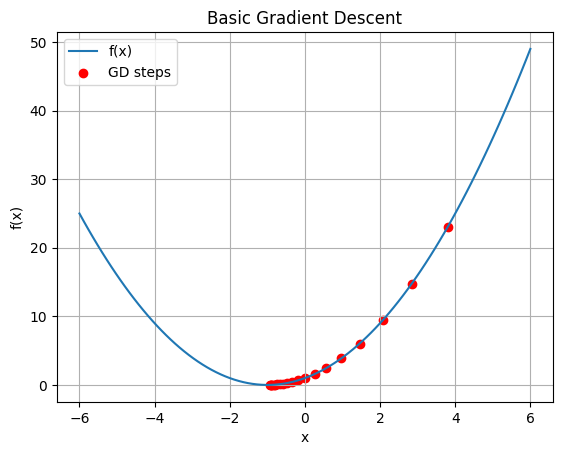


2D Gradient Descent:
Iteration 1: x = 2.4000, y = 3.2000, f(x,y) = 16.0000
Iteration 2: x = 1.9200, y = 2.5600, f(x,y) = 10.2400
Iteration 3: x = 1.5360, y = 2.0480, f(x,y) = 6.5536
Iteration 4: x = 1.2288, y = 1.6384, f(x,y) = 4.1943
Iteration 5: x = 0.9830, y = 1.3107, f(x,y) = 2.6844
Iteration 6: x = 0.7864, y = 1.0486, f(x,y) = 1.7180
Iteration 7: x = 0.6291, y = 0.8389, f(x,y) = 1.0995
Iteration 8: x = 0.5033, y = 0.6711, f(x,y) = 0.7037
Iteration 9: x = 0.4027, y = 0.5369, f(x,y) = 0.4504
Iteration 10: x = 0.3221, y = 0.4295, f(x,y) = 0.2882
Iteration 11: x = 0.2577, y = 0.3436, f(x,y) = 0.1845
Iteration 12: x = 0.2062, y = 0.2749, f(x,y) = 0.1181
Iteration 13: x = 0.1649, y = 0.2199, f(x,y) = 0.0756
Iteration 14: x = 0.1319, y = 0.1759, f(x,y) = 0.0484
Iteration 15: x = 0.1056, y = 0.1407, f(x,y) = 0.0309
Iteration 16: x = 0.0844, y = 0.1126, f(x,y) = 0.0198
Iteration 17: x = 0.0676, y = 0.0901, f(x,y) = 0.0127
Iteration 18: x = 0.0540, y = 0.0721, f(x,y) = 0.0081
Iteration 19:

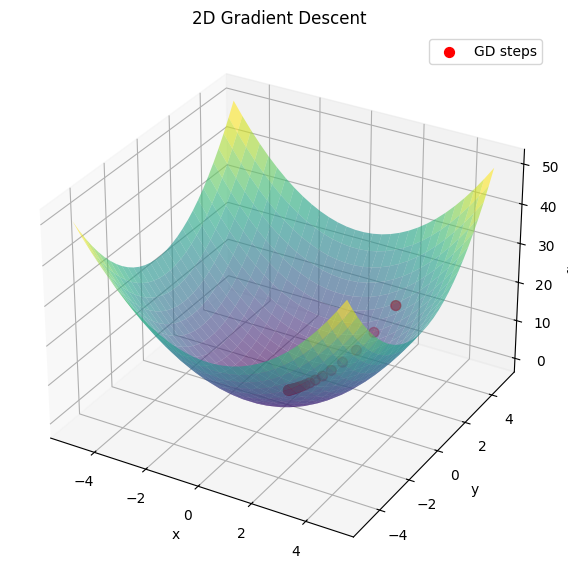


Neural Network Training with SGD:
Epoch [10/50], Loss: 1.0070
Epoch [20/50], Loss: 0.2764
Epoch [30/50], Loss: 0.1326
Epoch [40/50], Loss: 0.0979
Epoch [50/50], Loss: 0.0894


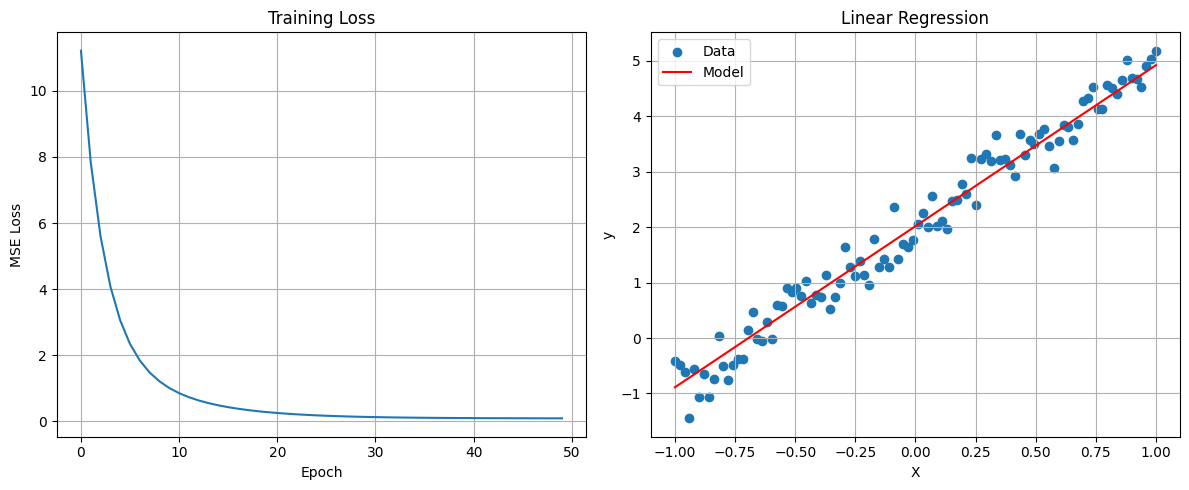

0.weight: [[2.9074042]]
0.bias: [2.0178883]


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from mpl_toolkits.mplot3d import Axes3D

# Set random seed for reproducibility
np.random.seed(42)
torch.manual_seed(42)

def basic_gradient_descent():
    # Define quadratic function: f(x) = x^2 + 2x + 1
    def f(x):
        return x**2 + 2*x + 1

    # Its derivative: f'(x) = 2x + 2
    def df(x):
        return 2*x + 2

    # Gradient descent parameters
    learning_rate = 0.1
    x = 5.0  # Initial guess
    iterations = 20

    # Store values for plotting
    history = []

    print("Basic Gradient Descent:")
    for i in range(iterations):
        grad = df(x)
        x = x - learning_rate * grad
        history.append((x, f(x)))
        print(f"Iteration {i+1}: x = {x:.4f}, f(x) = {f(x):.4f}, grad = {grad:.4f}")

    # Plot the results
    x_vals = np.linspace(-6, 6, 100)
    plt.plot(x_vals, f(x_vals), label='f(x)')
    plt.scatter([h[0] for h in history], [h[1] for h in history], c='red', label='GD steps')
    plt.title("Basic Gradient Descent")
    plt.xlabel("x")
    plt.ylabel("f(x)")
    plt.legend()
    plt.grid()
    plt.show()

# 2. Gradient Descent on a 2D Function (
def gradient_descent_2d():
    # Define the function: f(x,y) = x^2 + y^2
    def f(x, y):
        return x**2 + y**2

    # Gradients
    def df(x, y):
        return 2*x, 2*y

    # Parameters
    learning_rate = 0.1
    x, y = 3.0, 4.0  # Initial guess
    iterations = 20

    history = []

    print("\n2D Gradient Descent:")
    for i in range(iterations):
        grad_x, grad_y = df(x, y)
        x = x - learning_rate * grad_x
        y = y - learning_rate * grad_y
        history.append((x, y, f(x, y)))
        print(f"Iteration {i+1}: x = {x:.4f}, y = {y:.4f}, f(x,y) = {f(x,y):.4f}")

    # Create a 3D plot
    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    x_vals = np.linspace(-5, 5, 30)
    y_vals = np.linspace(-5, 5, 30)
    X, Y = np.meshgrid(x_vals, y_vals)
    Z = f(X, Y)

    ax.plot_surface(X, Y, Z, alpha=0.6, cmap='viridis')
    ax.scatter([h[0] for h in history], [h[1] for h in history], [h[2] for h in history],
               c='red', s=50, label='GD steps')

    ax.set_title("2D Gradient Descent")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("f(x,y)")
    plt.legend()
    plt.show()

# 3. Neural Network with PyTorch
def neural_network_example():
    # Create synthetic data
    X = torch.linspace(-1, 1, 100).view(-1, 1)
    y = 3 * X + 2 + 0.3 * torch.randn(X.size())

    # Define a simple linear model
    model = nn.Sequential(
        nn.Linear(1, 1)
    )

    # Loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.SGD(model.parameters(), lr=0.1)

    # Training loop
    epochs = 50
    losses = []

    print("\nNeural Network Training with SGD:")
    for epoch in range(epochs):
        # Forward pass
        outputs = model(X)
        loss = criterion(outputs, y)

        # Backward pass and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

        if (epoch+1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{epochs}], Loss: {loss.item():.4f}')

    # Plot the results
    plt.figure(figsize=(12, 5))

    # Plot loss curve
    plt.subplot(1, 2, 1)
    plt.plot(losses)
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("MSE Loss")
    plt.grid()

    # Plot regression line
    plt.subplot(1, 2, 2)
    plt.scatter(X.numpy(), y.numpy(), label='Data')
    with torch.no_grad():
        pred = model(X)
    plt.plot(X.numpy(), pred.numpy(), 'r-', label='Model')
    plt.title("Linear Regression")
    plt.xlabel("X")
    plt.ylabel("y")
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # Print final weights
    for name, param in model.named_parameters():
        if param.requires_grad:
            print(f"{name}: {param.data.numpy()}")

# Run all examples
basic_gradient_descent()
gradient_descent_2d()
neural_network_example()

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(131)
ds['Hs'].plot(levels=20, cmap='jet')
plt.title('Wave Height (Hs)')

plt.subplot(132)
ds['Tm'].plot(levels=20, cmap='viridis')
plt.title('Wave Period (Tm)')

plt.subplot(133)
ds['Dir'].plot(levels=36, cmap='hsv')
plt.title('Wave Direction (Dir)')
plt.tight_layout()
plt.show()